In [40]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [41]:
def process(traj, shieldings):
    output = {}
    output_error = {}

    number = traj[0].numbers

    for species in [1,6,7,8]:
        output[species] = []
        output_error[species] = []
        types = shieldings[np.where(number == species )[0]]
        for type in np.unique(types):
            output[species].append(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj])) 
            output_error[species].append(np.concatenate([frame.arrays['CSerr'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj]))       
    return output, output_error

def compute_averages(poly_cs, poly_cs_err):
    symbols = list(poly_cs.keys())
    averages = np.array([])
    errors = np.array([])
    for symbol in symbols:
        for ind, shielding in enumerate(poly_cs[symbol]):
            ave  = np.mean(shielding)

            N1 = len(shielding)
            N2 = len(poly_cs_err[symbol][ind])

            err1 = np.std(shielding)/np.sqrt(N1)
            err2 = np.sqrt(np.sum([i**2 for i in poly_cs_err[symbol][ind]]))/N2

            err = err1 + err2
            averages = np.append(averages, ave)
            errors = np.append(errors, err)
    return np.stack((averages, errors))
            


def plot_shieldings(shieldings_values, ax, fig, color="k", lab= "label", symbols_to_plot=None):
    labels = {1 : "H", 6: "C", 7 : "N", 8 : "O"}
    
    if symbols_to_plot == None:
        symbols = list(shieldings_values.keys())
    else:
        symbols = symbols_to_plot

    
    for ind, el in  zip(range(len(symbols)), symbols):
        if len(symbols) == 1:
            my_axis = ax
        else:
            my_axis = ax[ind]
        my_axis.tick_params(axis='both', which='major', labelsize=14)
        my_axis.tick_params(axis='both', which='minor', labelsize=12)

        for ind1, shielding in enumerate(shieldings_values[el]):
            if isinstance(shielding, (list, np.ndarray)) and len(shielding) >= 100:

                density = gaussian_kde(shielding)
                xs = np.linspace(min(shielding),max(shielding),200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                my_axis.plot(xs, density(xs), color=color)

            my_axis.vlines(np.mean(shielding), ymin= 0, ymax=0.3, colors=color, linestyles="dashed")
        my_axis.vlines(np.mean(shielding), ymin= 0, ymax=0.3, colors=color, linestyles="dashed", label= lab)

        my_axis.set_title(labels[symbols[ind]], fontsize=16)
    my_axis.set_xlabel("Shielding (ppm)", fontsize=16)

    my_axis.legend(fontsize=14)


In [4]:
edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}


colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [65]:
# load stuff

path_to_file = "PI_NVT/glycine_shieldings/"

base_fn = lambda poly, type, average: path_to_file + f'pi_nvt_{type}_glycine_{poly}_300K_00_w_cs{average}.xyz'

lmp_traj_alpha = read(base_fn('alpha', "lmp", ""),':')
lmp_traj_gamma  = read(base_fn('gamma', "lmp", ""),':')
lmp_traj_beta = read(base_fn('beta', "lmp", ""),':')

mlp_traj_alpha = read(base_fn('alpha', "mlp", ""),':')
mlp_traj_gamma  = read(base_fn('gamma', "mlp", ""),':')
mlp_traj_beta  = read(base_fn('beta', "mlp", ""),':')


lmp_traj_ave_alpha = read(base_fn('alpha', "lmp", "_averaged"),':')[0]
lmp_traj_ave_gamma  = read(base_fn('gamma', "lmp", "_averaged"),':')[0]
lmp_traj_ave_beta = read(base_fn('beta', "lmp", "_averaged"),':')[0]

mlp_traj_ave_alpha = read(base_fn('alpha', "mlp", "_averaged"),':')[0]
mlp_traj_ave_gamma  = read(base_fn('gamma', "mlp", "_averaged"),':')[0]
mlp_traj_ave_beta  = read(base_fn('beta', "mlp", "_averaged"),':')[0]

# load shieldings

path_to_init_file = "PI_NVT/"

base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'


alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

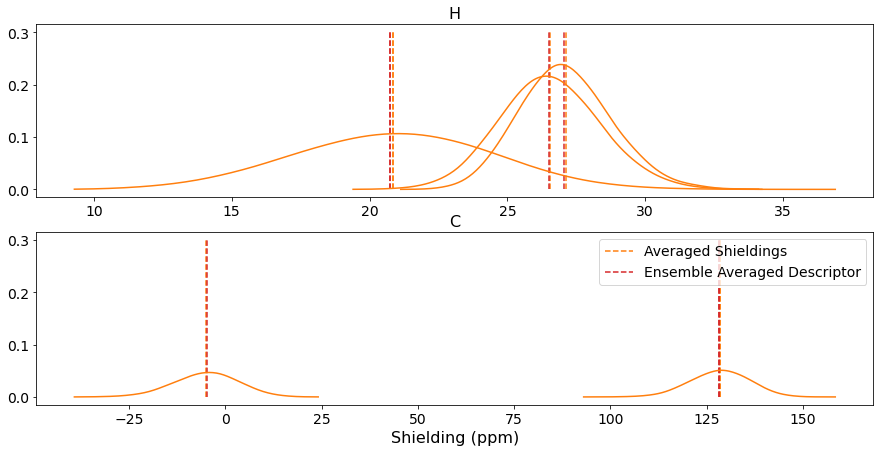

In [66]:
gamma_cs_lmp, gamma_cs_lmp_err  = process(lmp_traj_gamma, gamma_shieldings)
gamma_cs_mlp, gamma_cs_mlp_err = process(mlp_traj_gamma, gamma_shieldings)

gamma_cs_lmp_ave, _ = process([lmp_traj_ave_gamma], gamma_shieldings)
gamma_cs_mlp_ave, _ = process([mlp_traj_ave_gamma], gamma_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot ), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)


plot_shieldings(gamma_cs_lmp, ax, fig, colors[1], "Averaged Shieldings", symbols_to_plot = symbols_to_plot )
#plot_shieldings(gamma_cs_mlp, ax, fig, colors[0], "general potential", symbols_to_plot =symbols_to_plot )
plot_shieldings(gamma_cs_lmp_ave, ax, fig, colors[3], "Ensemble Averaged Descriptor", symbols_to_plot = symbols_to_plot )
#plot_shieldings(gamma_cs_mlp_ave, ax, fig, colors[3], "bespoke potential_averaged", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_gamma"], ax, fig, colors[4], "edgars_results", symbols_to_plot =symbols_to_plot )

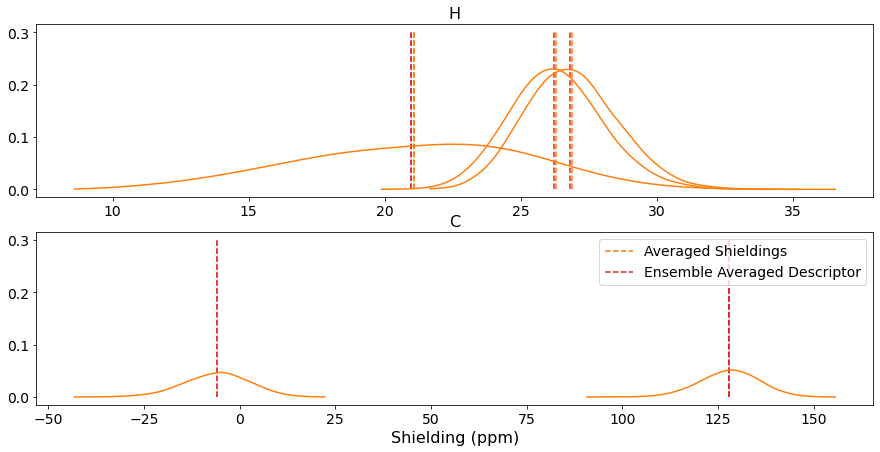

In [67]:
beta_cs_lmp, beta_cs_lmp_err = process(lmp_traj_beta, beta_shieldings)
beta_cs_mlp, beta_cs_mlp_err = process(mlp_traj_beta, beta_shieldings)

beta_cs_lmp_ave, _ = process([lmp_traj_ave_beta], beta_shieldings)
beta_cs_mlp_ave, _ = process([mlp_traj_ave_beta], beta_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)

plot_shieldings(beta_cs_lmp, ax, fig, colors[1], "Averaged Shieldings", symbols_to_plot = symbols_to_plot )
#plot_shieldings(beta_cs_mlp, ax, fig, colors[0], "general potential", symbols_to_plot =symbols_to_plot )
#plot_shieldings(beta_cs_mlp_ave, ax, fig, colors[2], "general potential_averaged", symbols_to_plot = symbols_to_plot )
plot_shieldings(beta_cs_lmp_ave, ax, fig, colors[3], "Ensemble Averaged Descriptor", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_beta"], ax, fig, colors[4], "edgars_results", symbols_to_plot = symbols_to_plot )

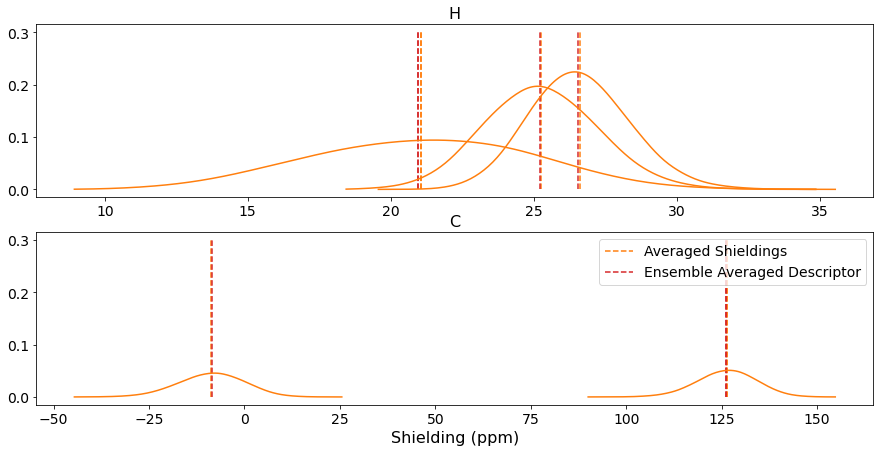

In [68]:
alpha_cs_lmp, alpha_cs_lmp_err = process(lmp_traj_alpha, alpha_shieldings)
alpha_cs_mlp, alpha_cs_mlp_err = process(mlp_traj_alpha, alpha_shieldings)

alpha_cs_lmp_ave, _ = process([lmp_traj_ave_alpha], alpha_shieldings)
alpha_cs_mlp_ave, _ = process([mlp_traj_ave_alpha], alpha_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)

plot_shieldings(alpha_cs_lmp, ax, fig, colors[1],  "Averaged Shieldings", symbols_to_plot = symbols_to_plot )
#plot_shieldings(alpha_cs_mlp, ax, fig, colors[0], "general potential", symbols_to_plot =symbols_to_plot )
#plot_shieldings(alpha_cs_mlp_ave, ax, fig, colors[2], "general potential_averaged", symbols_to_plot = symbols_to_plot )
plot_shieldings(alpha_cs_lmp_ave, ax, fig, colors[3], "Ensemble Averaged Descriptor", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_alpha"], ax, fig, colors[4], "edgars_results", symbols_to_plot =symbols_to_plot )

In [69]:
gamma_averages = compute_averages(gamma_cs_lmp, gamma_cs_lmp_err)
beta_averages = compute_averages(beta_cs_lmp, gamma_cs_lmp_err)
alpha_averages = compute_averages(alpha_cs_lmp, gamma_cs_lmp_err)


In [70]:
np.transpose(alpha_averages, axes=None), np.transpose(gamma_averages, axes=None), np.transpose(beta_averages, axes=None)

(array([[ 2.52576773e+01,  1.07295126e-02],
        [ 2.66089688e+01,  9.42449107e-03],
        [ 2.10685916e+01,  1.16937279e-02],
        [-8.65748349e+00,  4.55324234e-02],
        [ 1.26300875e+02,  4.35540054e-02],
        [ 1.91890812e+02,  6.93927213e-02],
        [-3.86907525e+01,  1.44885909e-01],
        [-5.67729987e+01,  1.51700035e-01]]),
 array([[ 2.65484458e+01,  1.13266232e-02],
        [ 2.71206068e+01,  1.02763403e-02],
        [ 2.08478008e+01,  1.24096751e-02],
        [-5.01218180e+00,  5.11621319e-02],
        [ 1.28341317e+02,  4.91668741e-02],
        [ 1.91362079e+02,  7.93780215e-02],
        [-3.72478470e+01,  1.72444974e-01],
        [-3.36997684e+01,  1.61611898e-01]]),
 array([[ 2.63016068e+01,  1.29501115e-02],
        [ 2.68880906e+01,  1.26957165e-02],
        [ 2.10928089e+01,  1.77764667e-02],
        [-5.97313718e+00,  6.31075516e-02],
        [ 1.27997505e+02,  5.94848646e-02],
        [ 1.94208347e+02,  9.09593173e-02],
        [-3.24581737e+01,  1

In [27]:
np.savetxt("results.txt", np.transpose(alpha_averages, axes=None))

In [32]:
np.savetxt("results.txt", np.transpose(beta_averages, axes=None))

In [33]:
np.savetxt("results.txt", np.transpose(gamma_averages, axes=None))


In [71]:
lmp_traj_alpha_emma = read("PI_NVT/glycine_shieldings/" +  'pi_nvt_lmp_glycine_alpha_300K_00_w_cs_emma_init_averaged.xyz' ,":")
lmp_traj_beta_emma = read("PI_NVT/glycine_shieldings/" +  'pi_nvt_lmp_glycine_beta_300K_00_w_cs_emma_init_averaged.xyz' ,":")
# load shieldings

path_to_init_file = "PI_NVT/"

base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'


alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")


beta_edgar_shield = read(path_to_init_file + f'glycine_beta/beta_init_edgar.xyz', ":" )[0].get_array("shieldings")

In [62]:
a,b = process(lmp_traj_alpha_emma, alpha_shieldings)
ave= compute_averages(a,b)
np.savetxt("results.txt", np.transpose(ave, axes=None))
np.transpose(ave, axes=None)

array([[ 2.49709499e+01,  7.07136058e-02],
       [ 2.60500415e+01,  6.80311540e-02],
       [ 2.07062756e+01,  6.78254556e-01],
       [-9.56322731e+00,  2.65342783e-01],
       [ 1.25870385e+02,  2.55102647e-01],
       [ 1.91208950e+02,  3.80500057e-01],
       [-3.49127606e+01,  1.97649999e+00],
       [-6.74887882e+01,  1.57099230e+00]])

In [72]:
a,b = process(lmp_traj_beta_emma, beta_edgar_shield)
ave= compute_averages(a,b)
np.savetxt("results.txt", np.transpose(ave, axes=None))
np.transpose(ave, axes=None)

array([[ 2.62402006e+01,  1.32974635e-01],
       [ 2.68337264e+01,  1.30546806e-01],
       [ 2.10215486e+01,  1.22788850e+00],
       [-5.59678801e+00,  3.74081852e-01],
       [ 1.27780928e+02,  5.36510635e-01],
       [ 1.94227062e+02,  7.47845807e-01],
       [-5.13802240e+01,  2.72129327e+00],
       [-3.26271094e+01,  3.87837700e+00]])